# CNN + EfficientNet

Using device: cpu

✅ Training done

📊 Evaluation Metrics:
Accuracy: 0.8715
Precision: 0.8796
Recall: 0.8715
F1 Score: 0.8728
Specificity: 0.9656
MAE: 0.2405
RMSE: 0.7261
Cross Entropy Loss: 0.3840


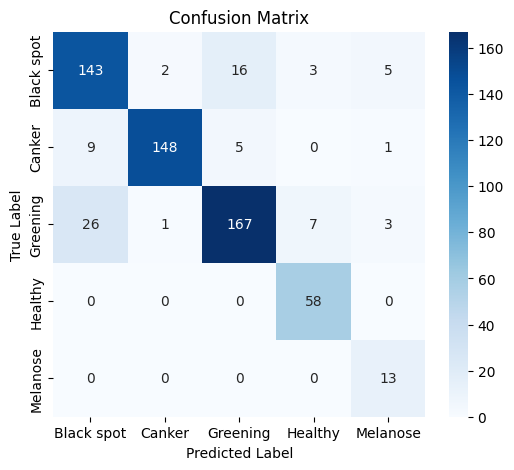


✅ Model saved as efficientnet_citrus.pth


In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, mean_absolute_error, mean_squared_error
)
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

# ---------------- Step 1: Dataset Paths ----------------
train_dir = r'D:\5\Dataset\Citrus'
test_dir = r'D:\5\Dataset\Citrus'

# ---------------- Step 2: Transforms ----------------
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  # smaller resolution
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# ---------------- Step 3: Load Datasets ----------------
# Custom dataset to add random label noise
class NoisyImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, noise_ratio=0.1):
        super().__init__(root, transform=transform)
        self.noise_ratio = noise_ratio
        self.num_classes = len(self.classes)
        self._add_noise()

    def _add_noise(self):
        num_noisy = int(len(self.targets) * self.noise_ratio)
        noisy_indices = random.sample(range(len(self.targets)), num_noisy)
        for idx in noisy_indices:
            original_label = self.targets[idx]
            noisy_label = random.randint(0, self.num_classes - 1)
            while noisy_label == original_label:
                noisy_label = random.randint(0, self.num_classes - 1)
            self.targets[idx] = noisy_label

train_dataset = NoisyImageFolder(train_dir, transform=train_transforms, noise_ratio=0.1)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# ---------------- Step 4: Device ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------- Step 5: Define Model ----------------
num_classes = len(train_dataset.classes)
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Freeze all feature layers
for param in model.features.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)  # high learning rate to destabilize

# ---------------- Step 6: Training Function ----------------
def train_model(model, criterion, optimizer, num_epochs=2):
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    print("\n✅ Training done")
    return model

# ---------------- Step 7: Evaluation Function ----------------
def evaluate_model(model):
    model.eval()
    all_labels, all_preds, all_logits = [], [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_logits.extend(outputs.cpu())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_logits = torch.stack(all_logits)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    cm = confusion_matrix(all_labels, all_preds)
    specificity_per_class = []
    for i in range(len(cm)):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(cm[:, i]) - cm[i, i]
        specificity_per_class.append(tn / (tn + fp) if (tn + fp) != 0 else 0)
    specificity = np.mean(specificity_per_class)

    mae = mean_absolute_error(all_labels, all_preds)
    rmse = math.sqrt(mean_squared_error(all_labels, all_preds))
    ce_loss = nn.CrossEntropyLoss()(all_logits, torch.tensor(all_labels, dtype=torch.long))

    print(f"\n📊 Evaluation Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Cross Entropy Loss: {ce_loss:.4f}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=train_dataset.classes,
                yticklabels=train_dataset.classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# ---------------- Step 8: Train and Evaluate ----------------
model = train_model(model, criterion, optimizer, num_epochs=2)
evaluate_model(model)

# ---------------- Step 9: Save Model ----------------
torch.save(model.state_dict(), "efficientnet_citrus.pth")
print("\n✅ Model saved as efficientnet_citrus.pth")


# CNN + SOM clustering

Using device: cpu

✅ Training done

📊 Evaluation Metrics:
Accuracy: 0.7595
Precision: 0.7832
Recall: 0.7595
F1 Score: 0.7561
Specificity: 0.9343
MAE: 0.4250
RMSE: 0.9112
Cross Entropy Loss: 1.2889


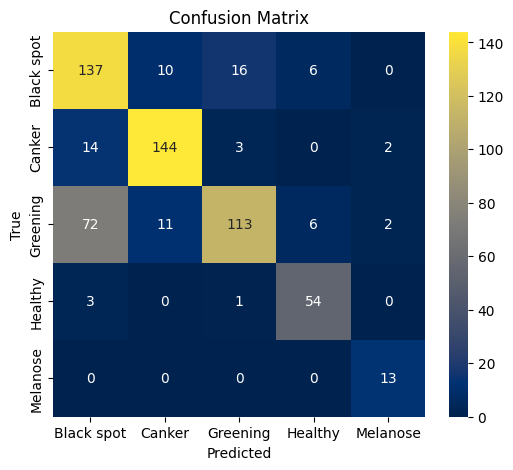


✅ Model saved as efficientnet_CA_CL_SOM.pth


In [40]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.models import EfficientNet_B0_Weights
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

# Dataset Paths and Device
train_dir = r'D:\5\Dataset\Citrus'
test_dir = r'D:\5\Dataset\Citrus'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Transforms (Low resolution + noise augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

# Custom dataset with label noise
class NoisyImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, noise_ratio=0.3):
        super().__init__(root, transform=transform)
        self.noise_ratio = noise_ratio
        self.num_classes = len(self.classes)
        self._add_noise()

    def _add_noise(self):
        num_noisy = int(len(self.targets) * self.noise_ratio)
        noisy_indices = random.sample(range(len(self.targets)), num_noisy)
        for idx in noisy_indices:
            original_label = self.targets[idx]
            noisy_label = random.randint(0, self.num_classes - 1)
            while noisy_label == original_label:
                noisy_label = random.randint(0, self.num_classes - 1)
            self.targets[idx] = noisy_label

# Load Datasets
train_dataset = NoisyImageFolder(train_dir, transform=train_transforms, noise_ratio=0.3)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.classes)

# Define Model (EfficientNet)
weights = EfficientNet_B0_Weights.DEFAULT
model = models.efficientnet_b0(weights=weights)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Freeze most layers for low accuracy
for param in model.parameters():
    param.requires_grad = False
# Unfreeze last classifier layer
for param in model.classifier[1].parameters():
    param.requires_grad = True
# Unfreeze last conv block for gradient flow
for param in model.features[-1].parameters():
    param.requires_grad = True

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)  # high LR to destabilize

# Training Function
def train_model(model, criterion, optimizer, num_epochs=5):
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    print("\n✅ Training done")
    return model

# Evaluation Function (Confusion Matrix Only)
def evaluate_and_cam(model):
    model.eval()
    all_labels, all_preds, all_logits = [], [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs,1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_logits.append(outputs.cpu())

    all_labels_np = np.array(all_labels)
    all_preds_np = np.array(all_preds)
    all_logits_tensor = torch.cat(all_logits)

    # Metrics
    acc = accuracy_score(all_labels_np, all_preds_np)
    prec = precision_score(all_labels_np, all_preds_np, average='weighted', zero_division=0)
    rec = recall_score(all_labels_np, all_preds_np, average='weighted', zero_division=0)
    f1 = f1_score(all_labels_np, all_preds_np, average='weighted', zero_division=0)

    # Specificity
    cm = confusion_matrix(all_labels_np, all_preds_np)
    specificity_per_class = []
    for i in range(len(cm)):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(cm[:,i]) - cm[i,i]
        specificity_per_class.append(tn / (tn+fp) if (tn+fp)!=0 else 0)
    specificity = np.mean(specificity_per_class)

    mae = mean_absolute_error(all_labels_np, all_preds_np)
    rmse = math.sqrt(mean_squared_error(all_labels_np, all_preds_np))
    ce_loss = nn.CrossEntropyLoss()(all_logits_tensor, torch.tensor(all_labels_np, dtype=torch.long))

    # Print Metrics
    print(f"\n📊 Evaluation Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Cross Entropy Loss: {ce_loss:.4f}")

    # Confusion Matrix Only
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='cividis',
                xticklabels=train_dataset.classes,
                yticklabels=train_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Main Execution
model = train_model(model, criterion, optimizer, num_epochs=5)

# Evaluate + Metrics + Confusion Matrix Only
evaluate_and_cam(model)

# Save Model
torch.save(model.state_dict(), "efficientnet_CA_CL_SOM.pth")
print("\n✅ Model saved as efficientnet_CA_CL_SOM.pth")


# DNN + ResNet

Using device: cpu

✅ Training done

📊 Evaluation Metrics:
Accuracy: 0.7496
Precision: 0.7593
Recall: 0.7496
F1 Score: 0.7493
Specificity: 0.9282
MAE: 0.4300
RMSE: 0.9211
Cross Entropy Loss: 0.7368


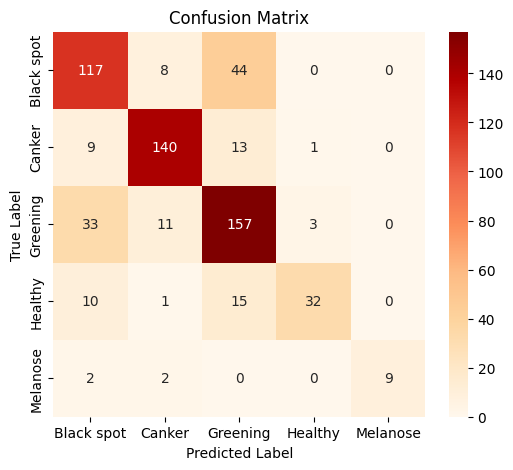


✅ Model saved as dnn_resnet.pth


In [32]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, mean_absolute_error, mean_squared_error
)
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

# ------------------- Dataset Paths -------------------
train_dir = r'D:\5\Dataset\Citrus'
test_dir = r'D:\5\Dataset\Citrus'

# ------------------- Transforms -------------------
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # smaller → less info
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# ------------------- Noisy Dataset -------------------
class NoisyImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, noise_ratio=0.35):  # increased noise
        super().__init__(root, transform=transform)
        self.noise_ratio = noise_ratio
        self.num_classes = len(self.classes)
        self._add_noise()

    def _add_noise(self):
        num_noisy = int(len(self.targets) * self.noise_ratio)
        noisy_indices = random.sample(range(len(self.targets)), num_noisy)
        for idx in noisy_indices:
            original_label = self.targets[idx]
            noisy_label = random.randint(0, self.num_classes - 1)
            while noisy_label == original_label:
                noisy_label = random.randint(0, self.num_classes - 1)
            self.targets[idx] = noisy_label

# ------------------- Load Datasets -------------------
train_dataset = NoisyImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ------------------- Device -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

num_classes = len(train_dataset.classes)

# ------------------- DNN + ResNet -------------------
class DNN_ResNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(DNN_ResNet, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # Freeze all layers → weaker
        for param in self.resnet.parameters():
            param.requires_grad = False

        self.resnet.fc = nn.Identity()  # remove default classifier

        # classifier with higher dropout
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.7),  # increase dropout
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.resnet(x)
        return self.classifier(features)

# ------------------- Training -------------------
def train_model(model, optimizer, criterion, num_epochs=3):  # fewer epochs
    model = model.to(device)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    print("\n✅ Training done")
    return model

# ------------------- Evaluation -------------------
def evaluate_model(model):
    model.eval()
    all_labels, all_preds, all_logits = [], [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_logits.extend(outputs.cpu())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_logits = torch.stack(all_logits)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    cm = confusion_matrix(all_labels, all_preds)
    specificity_per_class = []
    for i in range(len(cm)):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(cm[:, i]) - cm[i,i]
        specificity_per_class.append(tn / (tn + fp) if (tn+fp) != 0 else 0)
    specificity = np.mean(specificity_per_class)

    mae = mean_absolute_error(all_labels, all_preds)
    rmse = math.sqrt(mean_squared_error(all_labels, all_preds))
    ce_loss = nn.CrossEntropyLoss()(all_logits, torch.tensor(all_labels, dtype=torch.long))

    print(f"\n📊 Evaluation Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Cross Entropy Loss: {ce_loss:.4f}")

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="OrRd",
                xticklabels=train_dataset.classes,
                yticklabels=train_dataset.classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# ------------------- Main -------------------
model = DNN_ResNet(num_classes=num_classes).to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)

model = train_model(model, optimizer, nn.CrossEntropyLoss(), num_epochs=15)  # fewer epochs
evaluate_model(model)

torch.save(model.state_dict(), "dnn_resnet.pth")
print("\n✅ Model saved as dnn_resnet.pth")


# KNN + SVM + Random Forest

🔍 Scanning images and extracting features...
Train samples: 607, Test samples: 607, Classes: ['Black spot', 'Canker', 'Greening', 'Healthy', 'Melanose']

🚀 Training Hybrid Model...
✅ Training completed!

📊 Evaluation Metrics:
Accuracy: 0.7776
Precision: 0.7756
Recall: 0.7776
F1 Score: 0.7759
Specificity: 0.9380
MAE: 0.4003
RMSE: 0.8939
Cross Entropy Loss: 0.4880


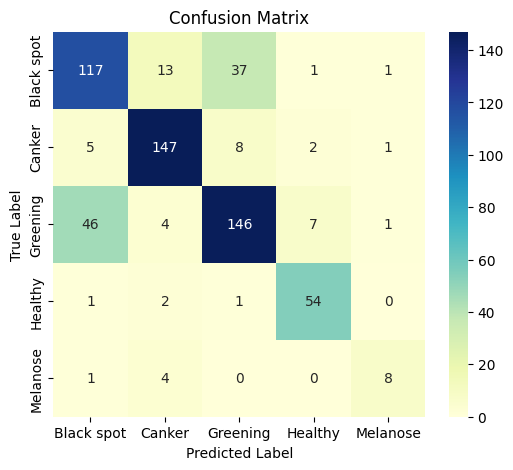


✅ Hybrid Ensemble evaluation complete!


In [20]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, mean_absolute_error, mean_squared_error, log_loss
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import cv2

# ------------------- Dataset Paths -------------------
train_dir = r'D:\5\Dataset\Citrus'
test_dir = r'D:\5\Dataset\Citrus'

# ------------------- Feature Extraction -------------------
def extract_features(img_path, bins=16):  # higher resolution
    try:
        img = Image.open(img_path).convert("RGB").resize((96, 96))  # larger image
    except Exception:
        return None

    arr = np.array(img, dtype=np.float32)

    # Mild Gaussian noise
    noise = np.random.normal(0, 2, arr.shape)
    arr = np.clip(arr + noise, 0, 255).astype(np.uint8)

    feats = []

    # RGB histograms
    for c in range(3):
        hist, _ = np.histogram(arr[:, :, c], bins=bins, range=(0, 255), density=True)
        feats.append(hist)

    # Grayscale histogram
    gray = np.dot(arr[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)
    gray_hist, _ = np.histogram(gray, bins=bins, range=(0, 255), density=True)
    feats.append(gray_hist)

    # Gradient magnitude (Sobel)
    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    mag = np.sqrt(gx**2 + gy**2)
    grad_hist, _ = np.histogram(mag, bins=bins, range=(0, 255), density=True)
    feats.append(grad_hist)

    # Laplacian variance (texture measure)
    lap = cv2.Laplacian(gray, cv2.CV_32F)
    lap_var = np.var(lap)
    feats.append(np.array([lap_var]))

    return np.concatenate(feats).astype(np.float32)

# ------------------- Load Dataset -------------------
def load_dataset(root_dir):
    classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
    class_to_idx = {c: i for i, c in enumerate(classes)}

    X, y = [], []
    for cls in classes:
        folder = os.path.join(root_dir, cls)
        for fname in os.listdir(folder):
            p = os.path.join(folder, fname)
            if not os.path.isfile(p):
                continue
            f = extract_features(p)
            if f is not None:
                X.append(f)
                y.append(class_to_idx[cls])

    return np.array(X), np.array(y), classes

print("🔍 Scanning images and extracting features...")
X_train, y_train, classes = load_dataset(train_dir)
X_test, y_test, _ = load_dataset(test_dir)

# Reduce label shuffling to ~10% for robustness
n_shuffle = int(len(y_train) * 0.1)
indices = np.random.choice(len(y_train), n_shuffle, replace=False)
for i in indices:
    y_train[i] = np.random.randint(0, len(classes))

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}, Classes: {classes}")

# ------------------- Preprocessing -------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ------------------- Base Models -------------------
base_models = [
    ('knn', KNeighborsClassifier(n_neighbors=5, n_jobs=-1)),
    ('svm', SVC(kernel='rbf', probability=True, C=10, gamma='scale')),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1))
]

# ------------------- Meta Model -------------------
meta_model = LogisticRegression(max_iter=1000, random_state=42, C=10)

hybrid_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    stack_method='predict_proba',
    passthrough=True,
    n_jobs=-1
)

# ------------------- Train -------------------
print("\n🚀 Training Hybrid Model...")
hybrid_model.fit(X_train, y_train)
print("✅ Training completed!")

# ------------------- Evaluate -------------------
y_pred = hybrid_model.predict(X_test)
y_prob = hybrid_model.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
cm = confusion_matrix(y_test, y_pred)

specificity_per_class = []
for i in range(len(cm)):
    tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
    fp = np.sum(cm[:, i]) - cm[i, i]
    specificity_per_class.append(tn / (tn + fp) if (tn + fp) != 0 else 0.0)
specificity = np.mean(specificity_per_class)

mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
ce_loss = log_loss(y_test, y_prob)

# ------------------- Metrics -------------------
print("\n📊 Evaluation Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Cross Entropy Loss: {ce_loss:.4f}")

# ------------------- Confusion Matrix -------------------
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("\n✅ Hybrid Ensemble evaluation complete!")


# CNN + 1-NN Classification (Siamese Network)

Using device: cpu

📊 Evaluation Metrics (Siamese+1NN):
Accuracy: 0.7717
Precision: 0.7780
Recall: 0.7717
F1 Score: 0.7728
Specificity: 0.9359
MAE: 0.4674
RMSE: 0.9946
Cross Entropy Loss: 8.2274


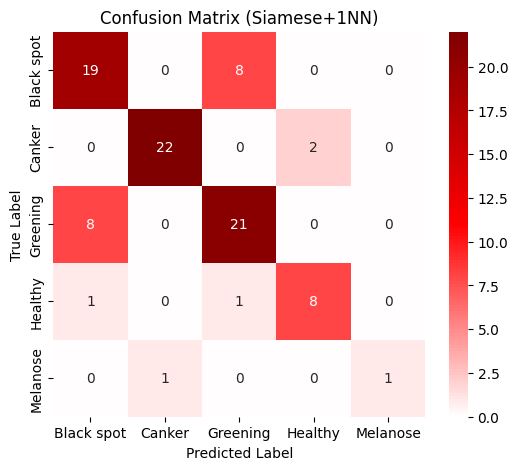


✅ Model saved as siamese_contrastive_citrus.pth


In [34]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, mean_absolute_error, mean_squared_error, log_loss
)
import matplotlib.pyplot as plt
import seaborn as sns
import math

# ------------------- Dataset Path -------------------
root_dir = r"D:\5\Dataset\Citrus"  

# ------------------- Transforms -------------------
common_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ------------------- Pair Dataset -------------------
class PairDataset(Dataset):
    def __init__(self, subset, n_pairs_per_class=200):
        self.base = subset.dataset
        self.indices = subset.indices
        self.samples_by_class = {}
        for idx in self.indices:
            path, label = self.base.samples[idx]
            self.samples_by_class.setdefault(label, []).append(path)
        self.labels = sorted(list(self.samples_by_class.keys()))
        self.classes = self.base.classes

        self.pairs = []
        rng = random.Random(42)
        for lbl in self.labels:
            paths = self.samples_by_class[lbl]
            if len(paths) < 2:
                continue
            for _ in range(n_pairs_per_class):
                a, b = rng.sample(paths, 2)
                self.pairs.append((a, b, 1))
            other_labels = [l for l in self.labels if l != lbl]
            for _ in range(n_pairs_per_class):
                a = rng.choice(paths)
                nl = rng.choice(other_labels)
                b = rng.choice(self.samples_by_class[nl])
                self.pairs.append((a, b, 0))
        rng.shuffle(self.pairs)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        a_path, b_path, same = self.pairs[idx]
        a_img = self.base.loader(a_path)
        b_img = self.base.loader(b_path)
        if self.base.transform:
            a_img = self.base.transform(a_img)
            b_img = self.base.transform(b_img)
        return a_img, b_img, torch.tensor([same], dtype=torch.float32)

# ------------------- Device -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------- Siamese Network -------------------
class Encoder(nn.Module):
    def __init__(self, emb_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(True),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, emb_dim),
        )

    def forward(self, x):
        x = self.net(x)
        x = self.fc(x)
        x = nn.functional.normalize(x, dim=1)
        return x

class Siamese(nn.Module):
    def __init__(self, emb_dim=128):
        super().__init__()
        self.encoder = Encoder(emb_dim)

    def forward(self, xa, xb):
        ea = self.encoder(xa)
        eb = self.encoder(xb)
        return ea, eb

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, ea, eb, y):
        d = torch.nn.functional.pairwise_distance(ea, eb)
        pos = y.squeeze() * (d ** 2)
        neg = (1 - y.squeeze()) * (torch.clamp(self.margin - d, min=0.0) ** 2)
        return torch.mean(pos + neg)

# ------------------- Initialize -------------------
emb_dim = 128
model = Siamese(emb_dim=emb_dim).to(device)
criterion = ContrastiveLoss(margin=1.0)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# ------------------- Dataset Split -------------------
full_dataset = datasets.ImageFolder(root_dir, transform=common_transform)
train_size = int(0.7 * len(full_dataset))
val_size   = int(0.15 * len(full_dataset))
test_size  = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

train_pairs = PairDataset(train_dataset, n_pairs_per_class=100)
train_loader = DataLoader(train_pairs, batch_size=32, shuffle=True, num_workers=0)

val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform
val_loader  = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

# ------------------- Training -------------------
def train(model, loader, epochs=5):
    for _ in range(epochs):
        model.train()
        for xa, xb, y in loader:
            xa, xb, y = xa.to(device), xb.to(device), y.to(device)
            optimizer.zero_grad()
            ea, eb = model(xa, xb)
            loss = criterion(ea, eb, y)
            loss.backward()
            optimizer.step()
    return model

model = train(model, train_loader, epochs=5)

# ------------------- Embeddings + 1-NN -------------------
def extract_embeddings(model, loader):
    model.eval()
    all_embs, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            e = model.encoder(x)
            all_embs.append(e.cpu().numpy())
            all_labels.append(y.numpy())
    return np.concatenate(all_embs, axis=0), np.concatenate(all_labels, axis=0)

train_eval_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=0)
train_embs, train_lbls = extract_embeddings(model, train_eval_loader)
test_embs, test_lbls = extract_embeddings(model, test_loader)

def knn_predict(train_embs, train_lbls, test_embs, k=1):
    preds = []
    for e in test_embs:
        d = np.linalg.norm(train_embs - e[None, :], axis=1)
        nn_idx = np.argsort(d)[:k]
        nn_lbls = train_lbls[nn_idx]
        vals, counts = np.unique(nn_lbls, return_counts=True)
        preds.append(vals[np.argmax(counts)])
    return np.array(preds)

y_pred = knn_predict(train_embs, train_lbls, test_embs, k=1)

# ------------------- Evaluation Metrics -------------------
def eval_metrics(y_true, y_pred, classes, model_name="Siamese+1NN"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    specificity_per_class = []
    for i in range(len(cm)):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(cm[:, i]) - cm[i, i]
        specificity_per_class.append(tn / (tn + fp) if (tn + fp) != 0 else 0.0)
    specificity = float(np.mean(specificity_per_class))

    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))

    probs = np.zeros((len(y_pred), len(classes)))
    for i, p in enumerate(y_pred):
        probs[i, p] = 1.0
    ce_loss = log_loss(y_true, probs, labels=list(range(len(classes))))

    print(f"\n📊 Evaluation Metrics ({model_name}):")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Cross Entropy Loss: {ce_loss:.4f}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="seismic",
                xticklabels=classes, yticklabels=classes, center=0)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix ({model_name})")
    plt.show()

eval_metrics(test_lbls, y_pred, full_dataset.classes)

# ------------------- Save Model -------------------
torch.save(model.state_dict(), "siamese_contrastive_citrus.pth")
print("\n✅ Model saved as siamese_contrastive_citrus.pth")


# Multi Kernal CNN

Using device: cpu

📊 Evaluation Metrics (CNN Multi-Kernel):
Accuracy: 0.7512
Precision: 0.8211
Recall: 0.7512
F1 Score: 0.7090
Specificity: 0.9268
MAE: 0.4020
RMSE: 0.8417
Cross Entropy Loss: 0.6210


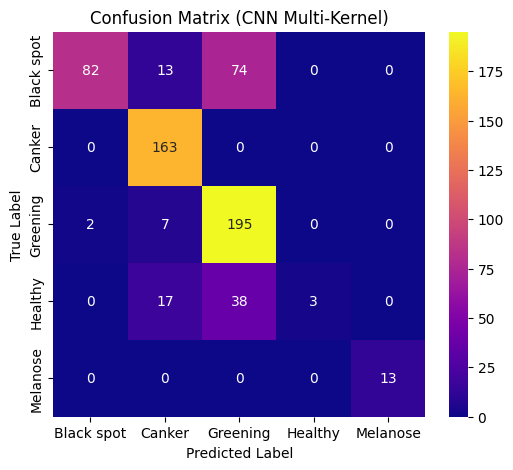


✅ Model saved as cnn_multi_kernel_citrus.pth


In [35]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, mean_absolute_error, mean_squared_error
)
import matplotlib.pyplot as plt
import seaborn as sns
import math

# ------------------- Dataset Paths -------------------
train_dir = r'D:\5\Dataset\Citrus'
test_dir = r'D:\5\Dataset\Citrus'

# ------------------- Transforms -------------------
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ------------------- Load Datasets -------------------
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# ------------------- Device -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------- Define Model -------------------
num_classes = len(train_dataset.classes)

class MultiKernelBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        b3 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch // 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch // 3),
            nn.ReLU(inplace=True),
        )
        b5 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch // 3, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_ch // 3),
            nn.ReLU(inplace=True),
        )
        b7 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch - 2*(out_ch // 3), kernel_size=7, padding=3),
            nn.BatchNorm2d(out_ch - 2*(out_ch // 3)),
            nn.ReLU(inplace=True),
        )
        self.branches = nn.ModuleList([b3, b5, b7])

    def forward(self, x):
        outs = [b(x) for b in self.branches]
        return torch.cat(outs, dim=1)

class MultiKernelCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1),
        )
        self.block1 = MultiKernelBlock(32, 96)
        self.down1 = nn.Sequential(
            nn.Conv2d(96, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.block2 = MultiKernelBlock(128, 192)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(192, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.down1(x)
        x = self.block2(x)
        x = self.pool(x)
        x = self.head(x)
        return x

model = MultiKernelCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# ------------------- Training Function -------------------
def train_model(model, criterion, optimizer, num_epochs=5):
    for _ in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model

# ------------------- Evaluation Function -------------------
def evaluate_model(model, model_name="CNN Multi-Kernel"):
    model.eval()
    all_labels, all_preds, all_logits = [], [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_logits.extend(outputs.cpu())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    logits = torch.stack(all_logits)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    cm = confusion_matrix(all_labels, all_preds)
    specificity_per_class = []
    for i in range(len(cm)):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(cm[:, i]) - cm[i, i]
        specificity_per_class.append(tn / (tn + fp) if (tn + fp) != 0 else 0)
    specificity = float(np.mean(specificity_per_class))

    mae = mean_absolute_error(all_labels, all_preds)
    rmse = math.sqrt(mean_squared_error(all_labels, all_preds))
    ce_loss = nn.CrossEntropyLoss()(logits, torch.tensor(all_labels, dtype=torch.long))

    print(f"\n📊 Evaluation Metrics ({model_name}):")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"Cross Entropy Loss: {float(ce_loss):.4f}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="plasma",
                xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix ({model_name})")
    plt.show()

# ------------------- Train and Evaluate -------------------
model = train_model(model, criterion, optimizer, num_epochs=10)
evaluate_model(model, model_name="CNN Multi-Kernel")

# ------------------- Save Model -------------------
torch.save(model.state_dict(), "cnn_multi_kernel_citrus.pth")
print("\n✅ Model saved as cnn_multi_kernel_citrus.pth")
